##Load txt file
The txt file is collected from https://www.gutenberg.org/files/84/84-h/84-h.htm

In [1]:
from google.colab import files
file = files.upload()

Saving Frankenstein.txt to Frankenstein.txt


In [2]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import load_model

import pickle
import numpy as np
import os

##Open and pre-process the data

In [3]:
file = open('Frankenstein.txt', 'r')

#Store data of the txt file in a list
doc = []
for i in file:
  doc.append(i)

# Convert list to string
data = ""
for i in doc:
  data = ' '. join(doc) 

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')\
            .replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space

In [4]:
#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
print(data[:100])
print(f"Total number of words is {len(data)}")

The Project Gutenberg eBook of Frankenstein, by Mary Wollstonecraft (Godwin) Shelley This eBook is f
Total number of words is 436916


##Apply tokenization and some other changes

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))
data_sequence = tokenizer.texts_to_sequences([data])[0]
print(data_sequence[:15])

[1, 99, 86, 683, 4, 301, 23, 2353, 2354, 2355, 2356, 25, 683, 31, 22]


In [6]:
print(f"length of data_sequence is {len(data_sequence)}")

length of data_sequence is 78466


Tri-gram based model

In [7]:
X,y  = [], []
k = 3
for i in range(k, len(data_sequence)):
    words = data_sequence[i-k:i+1]
    X.append(words[: k])
    y.append(words[k])
    
print("The Length of sequences are: ", len(X))
X = np.array(X)
y = np.array(y)
print(f"Data : \n{X[:10]}")
print(f"Response : \n{y[:10]}")

The Length of sequences are:  78463
Data : 
[[   1   99   86]
 [  99   86  683]
 [  86  683    4]
 [ 683    4  301]
 [   4  301   23]
 [ 301   23 2353]
 [  23 2353 2354]
 [2353 2354 2355]
 [2354 2355 2356]
 [2355 2356   25]]
Response : 
[ 683    4  301   23 2353 2354 2355 2356   25  683]


In [8]:
vocab_size = len(tokenizer.word_index) + 1 # 0 is reserved for padding and that's why we add 1
print(f"No of different words is {vocab_size}")

No of different words is 7495


In [9]:
y = to_categorical(y, num_classes = vocab_size)
print(y[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##Fit LSTM Model

In [10]:
model = Sequential(name='LSTM')
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(512, return_sequences=True))
model.add(LSTM(512))
model.add(Dense(512, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             74950     
                                                                 
 lstm (LSTM)                 (None, 3, 512)            1071104   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 7495)              3844935   
                                                                 
Total params: 7,352,845
Trainable params: 7,352,845
Non-trainable params: 0
_________________________________________________________________


Plot the model

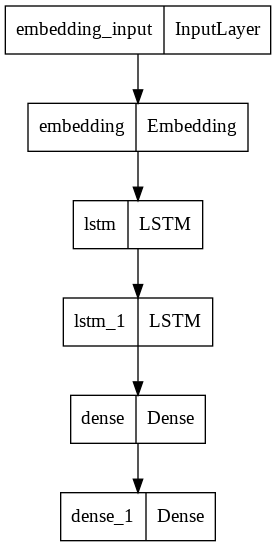

In [11]:
keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

In [12]:
checkpoint = ModelCheckpoint('next_words.h5', monitor = 'loss', verbose = 1, save_best_only = True)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 85, batch_size = 64, callbacks=[checkpoint])

Epoch 1/85
1226/1226 [==============================] - ETA: 0s - loss: 6.6283 - accuracy: 0.0614
Epoch 1: loss improved from inf to 6.62825, saving model to next_words.h5
1226/1226 [==============================] - 19s 9ms/step - loss: 6.6283 - accuracy: 0.0614
Epoch 2/85
1226/1226 [==============================] - ETA: 0s - loss: 6.1224 - accuracy: 0.0911
Epoch 2: loss improved from 6.62825 to 6.12241, saving model to next_words.h5
1226/1226 [==============================] - 11s 9ms/step - loss: 6.1224 - accuracy: 0.0911
Epoch 3/85
1222/1226 [============================>.] - ETA: 0s - loss: 5.7620 - accuracy: 0.1167
Epoch 3: loss improved from 6.12241 to 5.76160, saving model to next_words.h5
1226/1226 [==============================] - 11s 9ms/step - loss: 5.7616 - accuracy: 0.1168
Epoch 4/85
1221/1226 [============================>.] - ETA: 0s - loss: 5.4719 - accuracy: 0.1322
Epoch 4: loss improved from 5.76160 to 5.47128, saving model to next_words.h5
1226/1226 [=============

##Test the model

In [16]:
while True:
  text = input('Please enter sentence(Please write more than 2 words), 0 to exit: ')
  if text != '0':
    try:
      text = text.split(' ')
      text = text[-3: ]
      sequence = np.array(tokenizer.texts_to_sequences([text]))

      output = np.argpartition(model.predict(sequence)[0], -5)[-5:]
      preds = np.argmax(model.predict(sequence))
      predicted_word = ""    

      next_words = []
      for key, value in tokenizer.word_index.items():
        if value in output:
          next_words.append(key)

        if value == preds:
          predicted_word = key

        if len(next_words) == 5:
          break
      print(f"Possible predicted words:\n{next_words}")
      print(f"Most predicted word: {predicted_word}")
    except Exception as e:
      print(e)
  else:
    break

Please enter sentence(Please write more than 2 words), 0 to exit: Yet do not suppose
1/1 [==============================] - 0s 17ms/step
Possible predicted words:
['who', 'possessed', 'however', 'necessary', 'because']
Most predicted word: possessed
Please enter sentence(Please write more than 2 words), 0 to exit: My swelling heart
1/1 [==============================] - 0s 16ms/step
Possible predicted words:
['and', 'of', 'to', 'in', 'involuntarily']
Most predicted word: involuntarily
Please enter sentence(Please write more than 2 words), 0 to exit: Why not still proceed over the untamed yet obedient element? What can
1/1 [==============================] - 0s 14ms/step
Possible predicted words:
['i', 'my', 'you', 'be', 'have']
Most predicted word: be
Please enter sentence(Please write more than 2 words), 0 to exit: 0
